In [1]:
import shutil
import os
import pandas as pd

import matplotlib.pyplot as plt


In [2]:

working_dir = '/kaggle/working'

# Duyệt qua toàn bộ file/thư mục trong /kaggle/working
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Xóa file hoặc symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Xóa thư mục
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")


In [3]:

# 1. Đường dẫn dữ liệu
input_dir = '/kaggle/input/2017-isic/SegUNet_Final'

# Các thư mục ảnh
data_folders = [
    f'{input_dir}/ISIC-2017_Training_Data',
    f'{input_dir}/ISIC-2017_Test_v2_Data',
    f'{input_dir}/ISIC-2017_Validation_Data'
]

# Metadata của từng tập (train, test, val)
metadata_paths = [
    f'{input_dir}/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv',
    f'{input_dir}/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv',
    f'{input_dir}/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data_metadata.csv'
]

# Groundtruth phần 1 (Lesion segmentation)
ground1_folders = [
    
    f'{input_dir}/ISIC-2017_Training_Part1_GroundTruth',
    f'{input_dir}/ISIC-2017_Test_v2_Part1_GroundTruth',
    
    f'{input_dir}/ISIC-2017_Validation_Part1_GroundTruth'
]

# Groundtruth phần 2 (Lesion attribute segmentation)
ground2_folders = [
    f'{input_dir}/ISIC-2017_Training_Part2_GroundTruth',
    f'{input_dir}/ISIC-2017_Test_v2_Part2_GroundTruth',
    f'{input_dir}/ISIC-2017_Validation_Part2_GroundTruth'
]

# Các file groundtruth phần 3 (melanoma và seborrheic_keratosis)
csv_files = [
    f'{input_dir}/ISIC-2017_Training_Part3_GroundTruth.csv',
    f'{input_dir}/ISIC-2017_Test_v2_Part3_GroundTruth.csv',
    f'{input_dir}/ISIC-2017_Validation_Part3_GroundTruth.csv'
]


# 2. Tạo thư mục đầu ra
output_dir = '/kaggle/working/ISIC-2017'
dirs = {
    'train_data': os.path.join(output_dir, 'Train_Data'),
    'test_data': os.path.join(output_dir, 'Test_Data'),
    'train_gt1': os.path.join(output_dir, 'Train_GroundTruth_1'),
    'test_gt1': os.path.join(output_dir, 'Test_GroundTruth_1'),
    'train_gt2': os.path.join(output_dir, 'Train_GroundTruth_2'),
    'test_gt2': os.path.join(output_dir, 'Test_GroundTruth_2')
}
for d in dirs.values():
    os.makedirs(d, exist_ok=True)

# 3. Đọc CSV
df_list = []
for path in csv_files:
    df = pd.read_csv(path)
    
    # Giữ lại nếu có melanoma = 1 hoặc seborrheic_keratosis = 1 và xóa nếu cả 2 cùng bằng 0
    filtered = df[
        ((df['seborrheic_keratosis'] == 1) & (df['melanoma'] == 0)) |
        ((df['melanoma'] == 1) & (df['seborrheic_keratosis'] == 0))
    ]
    
    df_list.append(filtered)
    


merged_df = pd.concat(df_list, ignore_index=True)[['image_id', 'melanoma']]
merged_df

,image_id,melanoma
0,ISIC_0000002,1.0
1,ISIC_0000004,1.0
2,ISIC_0000013,1.0
3,ISIC_0000022,1.0
4,ISIC_0000026,1.0
...,...,...
902,ISIC_0014985,1.0
903,ISIC_0015062,0.0
904,ISIC_0015124,1.0
905,ISIC_0015243,1.0


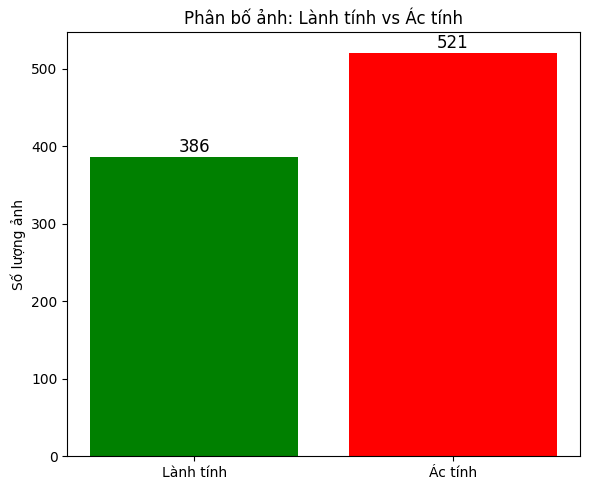

In [4]:
# Đếm số lượng theo nhãn
counts = merged_df['melanoma'].value_counts().sort_index()
labels = ['Lành tính', 'Ác tính']
colors = ['green', 'red']

# Vẽ biểu đồ
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=colors)

# Ghi số lượng trên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)

plt.title('Phân bố ảnh: Lành tính vs Ác tính')
plt.ylabel('Số lượng ảnh')
plt.tight_layout()
plt.show()

In [5]:
# Tạo bản sao và cột tên mới trong df1
df1 = merged_df.copy()
df1['new_image_id'] = [f'ISIC_{i+1:07d}' for i in range(len(df1))]
df1

,image_id,melanoma,new_image_id
0,ISIC_0000002,1.0,ISIC_0000001
1,ISIC_0000004,1.0,ISIC_0000002
2,ISIC_0000013,1.0,ISIC_0000003
3,ISIC_0000022,1.0,ISIC_0000004
4,ISIC_0000026,1.0,ISIC_0000005
...,...,...,...
902,ISIC_0014985,1.0,ISIC_0000903
903,ISIC_0015062,0.0,ISIC_0000904
904,ISIC_0015124,1.0,ISIC_0000905
905,ISIC_0015243,1.0,ISIC_0000906


In [6]:
# tiến hành chia train 70% và test 30%
# Lọc 2 nhóm: melanoma = 1 (bệnh) và melanoma = 0 (bình thường)
melanoma_df = df1[df1['melanoma'] == 1]
normal_df = df1[df1['melanoma'] == 0]

# Lấy 70% từ mỗi nhóm làm tập train
melanoma_train = melanoma_df.sample(frac=0.7, random_state=42)
normal_train = normal_df.sample(frac=0.7, random_state=42)

# Phần còn lại là test
melanoma_test = melanoma_df.drop(melanoma_train.index)
normal_test = normal_df.drop(normal_train.index)

# Gộp lại train và test
train_df = pd.concat([melanoma_train, normal_train], ignore_index=True).sample(frac=1, random_state=42)
test_df = pd.concat([melanoma_test, normal_test], ignore_index=True).sample(frac=1, random_state=42)

# In thông tin
print("✅ Số ảnh tập train:", len(train_df))
print(" - Số ảnh melanoma:", (train_df['melanoma'] == 1).sum())
print(" - Số ảnh bình thường:", (train_df['melanoma'] == 0).sum())

print("\n✅ Số ảnh tập test:", len(test_df))
print(" - Số ảnh melanoma:", (test_df['melanoma'] == 1).sum())
print(" - Số ảnh bình thường:", (test_df['melanoma'] == 0).sum())


✅ Số ảnh tập train: 635
 - Số ảnh melanoma: 365
 - Số ảnh bình thường: 270

✅ Số ảnh tập test: 272
 - Số ảnh melanoma: 156
 - Số ảnh bình thường: 116


In [7]:
# Đọc metadata
print("📦 Đang đọc metadata từ các file...")
all_metadata = pd.concat([pd.read_csv(p) for p in metadata_paths], ignore_index=True)


# ✅ Gộp với df1 để lấy new_image_id
metadata_with_new_id = all_metadata.merge(df1[['image_id', 'new_image_id']], on='image_id', how='left')


# ❌ Loại bỏ các dòng mà new_image_id bị NaN
metadata_with_new_id = metadata_with_new_id.dropna(subset=['new_image_id'])

# (Tùy chọn) Nếu muốn reset lại index
metadata_with_new_id = metadata_with_new_id.reset_index(drop=True)

# ✅ Cập nhật image_id bằng new_image_id nếu có
metadata_with_new_id['image_id'] = metadata_with_new_id['new_image_id'].combine_first(metadata_with_new_id['image_id'])

# ✅ Xoá cột phụ
metadata_with_new_id.drop(columns=['new_image_id'], inplace=True)

# Gán lại để tiếp tục sử dụng
all_metadata = metadata_with_new_id


all_metadata

📦 Đang đọc metadata từ các file...


,image_id,age_approximate,sex
0,ISIC_0000001,60,female
1,ISIC_0000002,80,male
2,ISIC_0000003,30,female
3,ISIC_0000004,55,female
4,ISIC_0000005,30,female
...,...,...,...
902,ISIC_0000903,60,male
903,ISIC_0000904,50,female
904,ISIC_0000905,45,male
905,ISIC_0000906,60,male


In [8]:
# ✅ Lọc metadata cho train/test
train_metadata = all_metadata[all_metadata['image_id'].isin(train_df['new_image_id'])]
test_metadata = all_metadata[all_metadata['image_id'].isin(test_df['new_image_id'])]

# ✅ Lưu file
train_meta_path = os.path.join(dirs['train_data'], 'Train_MetaData.csv')
test_meta_path = os.path.join(dirs['test_data'], 'Test_MetaData.csv')

train_metadata.to_csv(train_meta_path, index=False)
test_metadata.to_csv(test_meta_path, index=False)

print(f"✅ Đã lưu metadata train: {train_meta_path} ({len(train_metadata)} dòng)")
print(f"✅ Đã lưu metadata test: {test_meta_path} ({len(test_metadata)} dòng)")


✅ Đã lưu metadata train: /kaggle/working/ISIC-2017/Train_Data/Train_MetaData.csv (635 dòng)
✅ Đã lưu metadata test: /kaggle/working/ISIC-2017/Test_Data/Test_MetaData.csv (272 dòng)


In [9]:
# Danh sách ID tập train
train_ids = set(train_df['image_id'])  # train_df là DataFrame chứa tập huấn luyện

# Danh sách dòng hợp lệ (đã copy thành công)
valid_rows = []

# Lặp qua từng dòng trong df1 để xử lý copy và đổi tên
for idx, row in df1.iterrows():
    old_id = row['image_id']
    new_id = row['new_image_id']
    found = False

    for folder in data_folders:  # Danh sách thư mục chứa ảnh gốc
        src_img = os.path.join(folder, old_id + '.jpg')
        if os.path.exists(src_img):
            # Xác định tập train hay test
            if old_id in train_ids:
                data_dir = dirs['train_data']
                gt1_dir = dirs['train_gt1']
                gt2_dir = dirs['train_gt2']
            else:
                data_dir = dirs['test_data']
                gt1_dir = dirs['test_gt1']
                gt2_dir = dirs['test_gt2']

            # Copy ảnh chính
            dst_img = os.path.join(data_dir, new_id + '.jpg')
            shutil.copy(src_img, dst_img)
            found = True

            # Copy superpixel nếu có
            sp_src = os.path.join(folder, old_id + '_superpixels.png')
            sp_dst = os.path.join(data_dir, new_id + '_superpixels.png')
            if os.path.exists(sp_src):
                shutil.copy(sp_src, sp_dst)

            # Groundtruth 1 - segmentation
            for gt1 in ground1_folders:
                src = os.path.join(gt1, old_id + '_segmentation.png')
                if os.path.exists(src):
                    shutil.copy(src, os.path.join(gt1_dir, new_id + '_segmentation.png'))
                    break

            # Groundtruth 2 - features
            for gt2 in ground2_folders:
                src = os.path.join(gt2, old_id + '_features.json')
                if os.path.exists(src):
                    shutil.copy(src, os.path.join(gt2_dir, new_id + '_features.json'))
                    break

            valid_rows.append(row)
            break  # Dừng kiểm tra folder khi đã copy xong

    if not found:
        print(f"⚠️ Không tìm thấy ảnh: {old_id}")

    # In tiến độ
    if (idx + 1) % 50 == 0 or idx + 1 == len(df1):
        percent = (idx + 1) / len(df1) * 100
        print(f"✅ Đã xử lý {idx + 1}/{len(df1)} ảnh ({percent:.2f}%)")

print("🎉 Hoàn thành sao chép và cập nhật tên ảnh.")



✅ Đã xử lý 50/907 ảnh (5.51%)
✅ Đã xử lý 100/907 ảnh (11.03%)
✅ Đã xử lý 150/907 ảnh (16.54%)
✅ Đã xử lý 200/907 ảnh (22.05%)
✅ Đã xử lý 250/907 ảnh (27.56%)
✅ Đã xử lý 300/907 ảnh (33.08%)
✅ Đã xử lý 350/907 ảnh (38.59%)
✅ Đã xử lý 400/907 ảnh (44.10%)
✅ Đã xử lý 450/907 ảnh (49.61%)
✅ Đã xử lý 500/907 ảnh (55.13%)
✅ Đã xử lý 550/907 ảnh (60.64%)
✅ Đã xử lý 600/907 ảnh (66.15%)
✅ Đã xử lý 650/907 ảnh (71.66%)
✅ Đã xử lý 700/907 ảnh (77.18%)
✅ Đã xử lý 750/907 ảnh (82.69%)
✅ Đã xử lý 800/907 ảnh (88.20%)
✅ Đã xử lý 850/907 ảnh (93.72%)
✅ Đã xử lý 900/907 ảnh (99.23%)
✅ Đã xử lý 907/907 ảnh (100.00%)
🎉 Hoàn thành sao chép và cập nhật tên ảnh.


In [10]:
# Gán lại image_id trong train_df và test_df theo mapping mới
train_df['image_id'] = train_df['new_image_id']
test_df['image_id'] = test_df['new_image_id']

# Chọn cột cần thiết
train_df = train_df[['image_id', 'melanoma']]
test_df = test_df[['image_id', 'melanoma']]

# 🔤 Sắp xếp theo image_id
train_df = train_df.sort_values(by='image_id').reset_index(drop=True)
test_df = test_df.sort_values(by='image_id').reset_index(drop=True)

# ✅ Lưu file
train_gt3_path = os.path.join(output_dir, 'Train_GroundTruth_3.csv')
test_gt3_path = os.path.join(output_dir, 'Test_GroundTruth_3.csv')

train_df.to_csv(train_gt3_path, index=False)
test_df.to_csv(test_gt3_path, index=False)

print(f"✅ Đã lưu GroundTruth_3 train: {train_gt3_path} ({len(train_df)} dòng)")
print(f"✅ Đã lưu GroundTruth_3 test: {test_gt3_path} ({len(test_df)} dòng)")

✅ Đã lưu GroundTruth_3 train: /kaggle/working/ISIC-2017/Train_GroundTruth_3.csv (635 dòng)
✅ Đã lưu GroundTruth_3 test: /kaggle/working/ISIC-2017/Test_GroundTruth_3.csv (272 dòng)
